In [23]:
from pathlib import Path
import sys

REPO_ROOT = Path.cwd().resolve().parent
SRC_ROOT = REPO_ROOT / "src"
if str(SRC_ROOT) not in sys.path:
    sys.path.insert(0, str(SRC_ROOT))

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from problems.maxcut import generate_maxcut_instance
from problems.knapsack import generate_knapsack_instance, knapsack_to_ising, evaluate_knapsack_samples
from qaoa.circuits import CostHamiltonian, maxcut_hamiltonian
from qaoa.experiments import run_parameter_grid, run_depth_experiment
from qaoa.metrics import analyze_samples
from qaoa.knapsack_analysis import penalty_parameter_sweep
from visualization.landscapes import plot_parameter_landscape
from visualization.distributions import plot_energy_distribution, plot_penalty_tradeoff

In [25]:
maxcut_instance = generate_maxcut_instance(n_nodes=6, edge_probability=0.5, weighted=False, seed=1)
hamiltonian = maxcut_hamiltonian(maxcut_instance.weights, maxcut_instance.n_nodes)
energy_min = maxcut_instance.ground_state_energy
energy_max = maxcut_instance.energy_ceiling
print(f"Nodes: {maxcut_instance.n_nodes}, edges: {len(maxcut_instance.edge_list)}")
print(f"Ground-state energy: {energy_min:.3f}")
print(f"Number of optimal bitstrings: {len(maxcut_instance.ground_state_bitstrings)}")

Nodes: 6, edges: 7
Ground-state energy: -7.000
Number of optimal bitstrings: 2


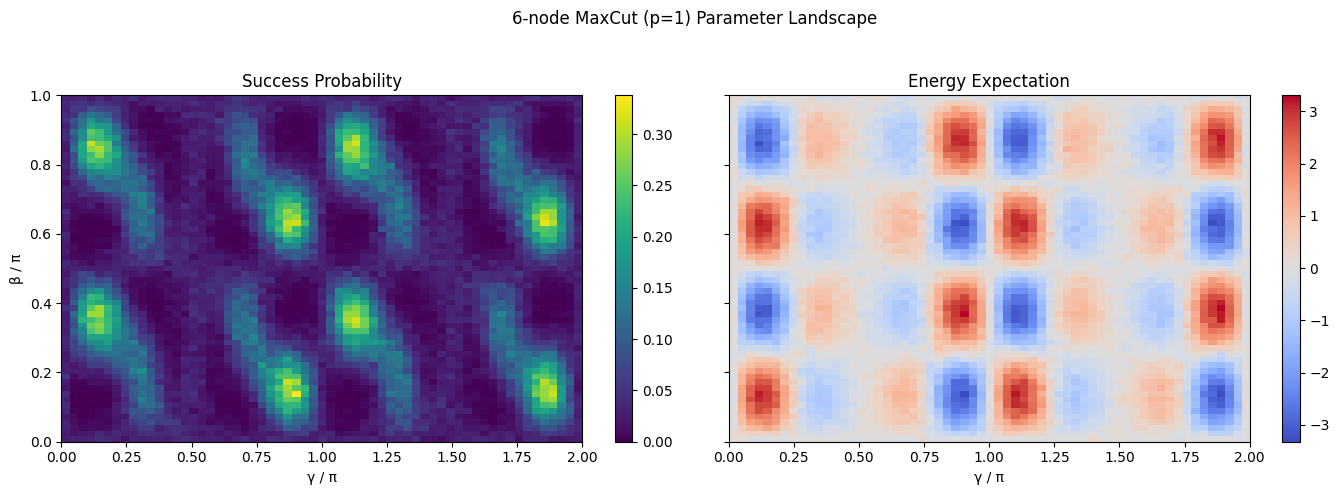

Best-energy params (gamma, beta): (np.float64(2.827433388230814), np.float64(0.41887902047863906))
Best-success params (gamma, beta): (np.float64(2.827433388230814), np.float64(0.41887902047863906))


In [26]:
gamma_vals = np.linspace(0, 2 * np.pi, 61)
beta_vals = np.linspace(0, np.pi, 61)
grid_run = run_parameter_grid(
    hamiltonian=hamiltonian,
    ground_states=maxcut_instance.ground_state_bitstrings,
    energy_min=energy_min,
    energy_max=energy_max,
    gamma_values=gamma_vals,
    beta_values=beta_vals,
    shots=512,
 )
grid = grid_run.grid
plot_parameter_landscape(
    grid.gamma_values,
    grid.beta_values,
    grid.energy_grid,
    grid.success_grid,
    problem_label="6-node MaxCut (p=1)",
)
print("Best-energy params (gamma, beta):", grid.best_energy_params)
print("Best-success params (gamma, beta):", grid.best_success_params)

In [27]:
opt_gamma = grid_run.parameters["gamma"][0]
opt_beta = grid_run.parameters["beta"][0]
analysis = grid_run.analysis
print(f"Optimal (gamma, beta) from heatmap: ({opt_gamma:.3f}, {opt_beta:.3f})")
print(f"Mean energy: {analysis.energy_mean:.3f}")
print(f"Energy std: {analysis.energy_std:.3f}")
print(f"Success probability: {analysis.success_probability:.3%}")
print(f"Approximation ratio: {analysis.approximation_ratio:.3f}")
pd.DataFrame(
    {
        "bitstring": list(grid_run.counts.keys()),
        "probability": np.array(list(grid_run.counts.values())) / sum(grid_run.counts.values()),
    }
 ).head()

Optimal (gamma, beta) from heatmap: (2.827, 0.419)
Mean energy: -3.080
Energy std: 2.836
Success probability: 27.930%
Approximation ratio: 0.720


,bitstring,probability
0,001110,0.000488
1,111111,0.000488
2,111011,0.002930
3,100001,0.000488
4,111001,0.000977


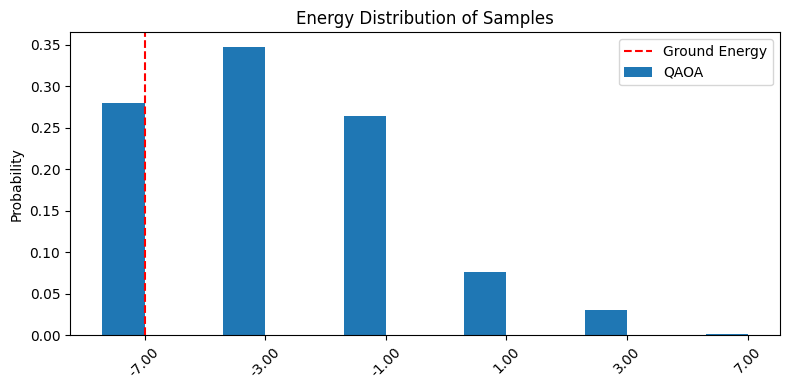

In [28]:
plot_energy_distribution(
    distribution=grid_run.analysis.energy_distribution,
    ground_energy=energy_min,
    comparison=None,
 )

In [29]:
knapsack_instance = generate_knapsack_instance(n_items=6, capacity_ratio=0.5, seed=2)
print("Values:", knapsack_instance.values)
print("Weights:", knapsack_instance.weights)
print(f"Capacity: {knapsack_instance.capacity:.1f}")
print(f"Optimal value (brute force): {knapsack_instance.optimal_value:.1f}")
print("Optimal selection:", knapsack_instance.optimal_selection)

Values: [18.0, 9.0, 6.0, 9.0, 11.0, 18.0]
Weights: [3.0, 1.0, 2.0, 4.0, 5.0, 4.0]
Capacity: 9.5
Optimal value (brute force): 45.0
Optimal selection: [1, 1, 0, 0, 0, 1]


In [30]:
penalty_lambda = 20.0
h_knap, J_knap, offset = knapsack_to_ising(
    knapsack_instance.values,
    knapsack_instance.weights,
    knapsack_instance.capacity,
    penalty_lambda,
 )
hamiltonian_knap = CostHamiltonian(h_knap, J_knap, knapsack_instance.n_items)
knapsack_run = run_depth_experiment(
    hamiltonian_knap,
    ground_states=["".join(map(str, knapsack_instance.optimal_selection))],
    energy_min=-knapsack_instance.optimal_value,
    energy_max=0.0,
    p=1,
    n_restarts=3,
    shots=512,
 )

In [31]:
knapsack_eval = evaluate_knapsack_samples(
    knapsack_run.counts,
    knapsack_instance.values,
    knapsack_instance.weights,
    knapsack_instance.capacity,
 )
best_value = knapsack_eval["best_feasible"]["value"] if knapsack_eval["best_feasible"] else 0.0
print(f"Feasibility rate: {knapsack_eval['feasibility_rate']:.2%}")
print(f"Best feasible value: {best_value:.1f} (opt={knapsack_instance.optimal_value:.1f})")
print(f"Approximation ratio: {best_value / knapsack_instance.optimal_value:.3f}")
print(f"Average violation (infeasible samples): {knapsack_eval['avg_violation']:.2f}")

Feasibility rate: 49.68%
Best feasible value: 45.0 (opt=45.0)
Approximation ratio: 1.000
Average violation (infeasible samples): 3.44


,feasibility_rate,approx_ratio,best_value,avg_violation
5.0,0.502441,1.000000,45.0,3.437500
10.0,0.593262,1.000000,45.0,3.500000
20.0,0.592285,0.933333,42.0,3.370968
40.0,0.643066,1.000000,45.0,3.568966
80.0,0.620605,1.000000,45.0,3.464286


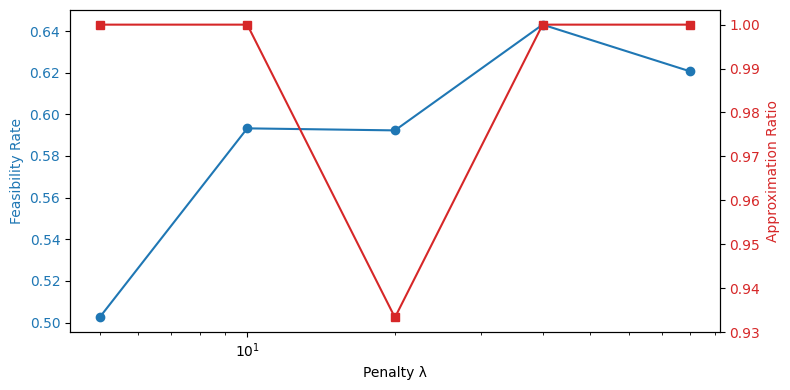

In [32]:
lambda_values = [5, 10, 20, 40, 80]
penalty_summary = penalty_parameter_sweep(
    instance=knapsack_instance,
    lambda_values=lambda_values,
    p=1,
    shots=256,
    n_restarts=2,
 )
penalty_df = pd.DataFrame.from_dict(penalty_summary, orient="index").sort_index()
display(penalty_df)
plot_penalty_tradeoff(
    penalty_df.index.tolist(),
    penalty_df["feasibility_rate"],
    penalty_df["approx_ratio"],
)